<a href="https://colab.research.google.com/github/desbaa32/Master2BD_tp_pro/blob/master/Indexation_visuelle_SerigneDabo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chargement de la base de données

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

URL transformed to HTTPS due to an HSTS policy
--2025-11-04 13:24:03--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  6.39MB/s    in 34s     

2025-11-04 13:24:37 (6.93 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]

Archive:  tiny-imagenet-200.zip
replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Indexation visuelle : SIFT, LBP, HOG, CNN embeddings

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from skimage.feature import local_binary_pattern
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.preprocessing import image

# --- Paramètres ---
DATASET_DIR = "tiny-imagenet-200/train"
NUM_CLASSES = 10  # on prend 10 classes pour simplifier
IMAGES_PER_CLASS = 5
IMAGE_SIZE = (128, 128)

# --- Charger un sous-ensemble du dataset ---
def load_dataset(path, num_classes=10, per_class=5):
    data = []
    labels = []
    class_folders = sorted(os.listdir(path))[:num_classes]
    for label, folder in enumerate(class_folders):
        img_dir = os.path.join(path, folder, 'images')
        imgs = sorted(os.listdir(img_dir))[:per_class]
        for img_name in imgs:
            img_path = os.path.join(img_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMAGE_SIZE)
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels), class_folders

images, labels, class_names = load_dataset(DATASET_DIR, NUM_CLASSES, IMAGES_PER_CLASS)
print(f"{len(images)} images chargées.")

# --- Méthodes d’indexation ---

# -----------------------------
#        SIFT (Couleur)
# -----------------------------
def extract_sift_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    return np.mean(des, axis=0) if des is not None else np.zeros(128)

def extract_orb_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(gray, None)
    return np.mean(des, axis=0) if des is not None else np.zeros(32)

# -----------------------------
#       LBP (Texture)
# -----------------------------
def extract_lbp_features(img, P=8, R=1):
    """
    LBP (Local Binary Pattern) : encode la texture locale.
    P = nombre de points voisins
    R = rayon
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalisation
    return hist

# -----------------------------
#         HOG (Forme)
# -----------------------------
def extract_hog_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor()
    return hog.compute(gray).flatten()

# -----------------------------
#  CNN Embeddings (ResNet18)
# -----------------------------
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_cnn_features(img):
    img_resized = cv2.resize(img, (224, 224))
    x = image.img_to_array(img_resized)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    feat = resnet.predict(x, verbose=0)
    return feat.flatten()

# --- Extraction ---
methods = {
    "SIFT": extract_sift_features,
    "LBP": extract_lbp_features,
    "HOG": extract_hog_features,
    "CNN": extract_cnn_features
}

features = {}
for name, func in methods.items():
    feats = [func(img) for img in tqdm(images, desc=f"Extraction {name}")]
    features[name] = np.array(feats)


# --- Recherche d’images similaires ---
"""----------------------------------------
-----------------------------------------
-----------------------------------------"""

50 images chargées.


Extraction CNN: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]


'----------------------------------------\n-----------------------------------------\n-----------------------------------------'

In [9]:
#1. TAILLE TOTALE DU SOUS-ENSEMBLE D'IMAGES CHARGÉ
print(f" Nombre total d'images: {len(images)}")
print(f" Taille mémoire : {images.nbytes / (1024*1024):.2f} MB")

#2. Classes et images par classe
print(f" Nombre de classes: {NUM_CLASSES}")
print(f" Images par classe: {IMAGES_PER_CLASS}")
print(f" Classes utilisées: {class_names}")

#3. TAILLE DES VECTEURS DE CARACTÉRISTIQUES
print("Taille des vecteurs:")
for method_name, method_features in features.items():
 if len(method_features) > 0:
  vector_size = method_features[0].shape[0]
  print(f"{method_name}: {vector_size} dimensions")

 Nombre total d'images: 50
 Taille mémoire : 2.34 MB
 Nombre de classes: 10
 Images par classe: 5
 Classes utilisées: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
Taille des vecteurs:
SIFT: 128 dimensions
LBP: 10 dimensions
HOG: 34020 dimensions
CNN: 2048 dimensions


Test de la recherche d'images similaires...


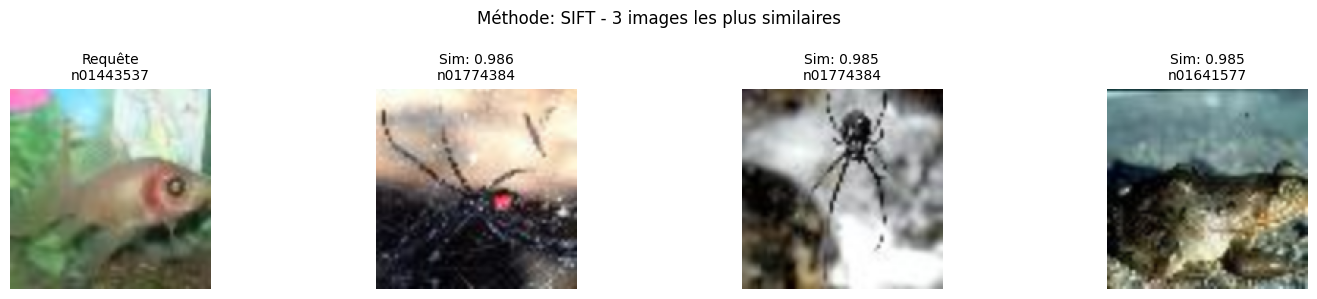


Résultats pour la méthode SIFT (Image requête: n01443537):
  Rang 1: Image 40 (n01774384) - Similarité: 0.9863
  Rang 2: Image 43 (n01774384) - Similarité: 0.9853
  Rang 3: Image 10 (n01641577) - Similarité: 0.9850


In [12]:

#4. Fonction de recherche d'images similaires ---
def rechercher_images_similaires(query_idx, methode, k=5):
    # Récupérer les caractéristiques de la méthode
    features_methode = features[methode]

    # Caractéristiques de l'image requête
    query_features = features_methode[query_idx]

    # Calcul des similarités cosinus avec toutes les images
    similarities = []
    for i, feat in enumerate(features_methode):
        if i != query_idx:
            if len(query_features) == len(feat):
                sim = cosine_similarity([query_features], [feat])[0][0]
                similarities.append((i, sim))

    # Trier
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:k]

# 5. Affichage des résultats ---
def afficher_resultats(query_idx, methode, k=5):

    # Recherche des images similaires
    images_similaires = rechercher_images_similaires(query_idx, methode, k)

    plt.figure(figsize=(15, 3))
    plt.subplot(1, k + 1, 1)
    plt.imshow(cv2.cvtColor(images[query_idx], cv2.COLOR_BGR2RGB))
    plt.title(f"Requête\n{class_names[labels[query_idx]]}", fontsize=10)
    plt.axis('off')

    # Images similaires
    for i, (img_idx, similarite) in enumerate(images_similaires):
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(cv2.cvtColor(images[img_idx], cv2.COLOR_BGR2RGB))
        plt.title(f"Sim: {similarite:.3f}\n{class_names[labels[img_idx]]}", fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Méthode: {methode} - {k} images les plus similaires", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Affichage textuel des résultats
    print(f"\nRésultats pour la méthode {methode} (Image requête: {class_names[labels[query_idx]]}):")
    for rang, (img_idx, similarite) in enumerate(images_similaires, 1):
        print(f"  Rang {rang}: Image {img_idx} ({class_names[labels[img_idx]]}) - Similarité: {similarite:.4f}")

# TEST
print("Test de la recherche d'images similaires...")
# Test avec une image requête
image_requete_idx = 0
methode_test = "SIFT"
k_test = 3

# Appel de la fonction
afficher_resultats(image_requete_idx, methode_test, k_test)

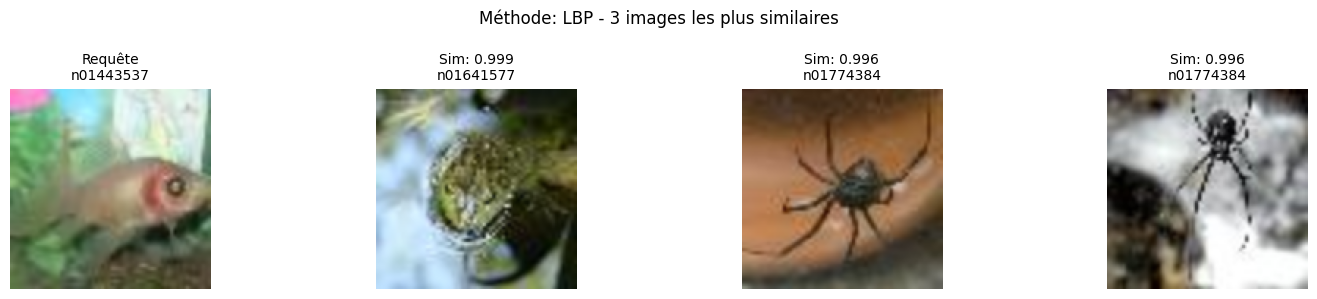


Résultats pour la méthode LBP (Image requête: n01443537):
  Rang 1: Image 13 (n01641577) - Similarité: 0.9990
  Rang 2: Image 44 (n01774384) - Similarité: 0.9960
  Rang 3: Image 43 (n01774384) - Similarité: 0.9959


In [13]:
# Test avec une image requête
image_requete_idx = 0
methode_test = "LBP"
k_test = 3

# Appel de la fonction
afficher_resultats(image_requete_idx, methode_test, k_test)

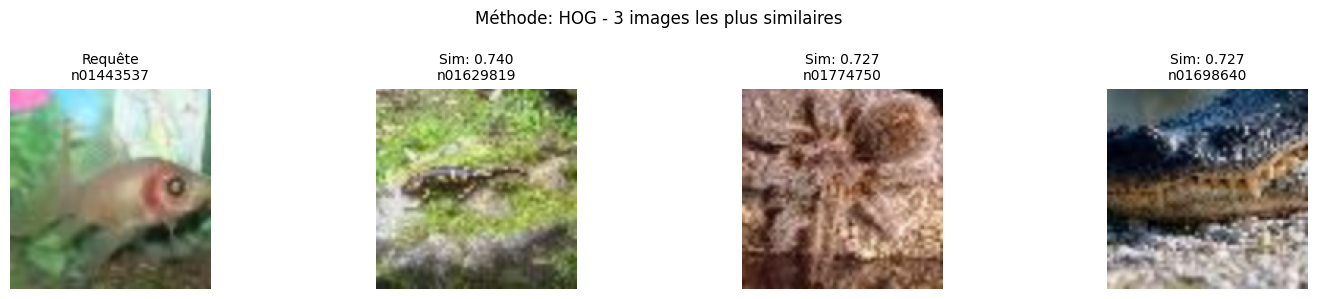


Résultats pour la méthode HOG (Image requête: n01443537):
  Rang 1: Image 9 (n01629819) - Similarité: 0.7400
  Rang 2: Image 48 (n01774750) - Similarité: 0.7274
  Rang 3: Image 23 (n01698640) - Similarité: 0.7268


In [14]:
# Test avec une image requête
image_requete_idx = 0
methode_test = "HOG" #"CNN"
k_test = 3

# Appel de la fonction
afficher_resultats(image_requete_idx, methode_test, k_test)

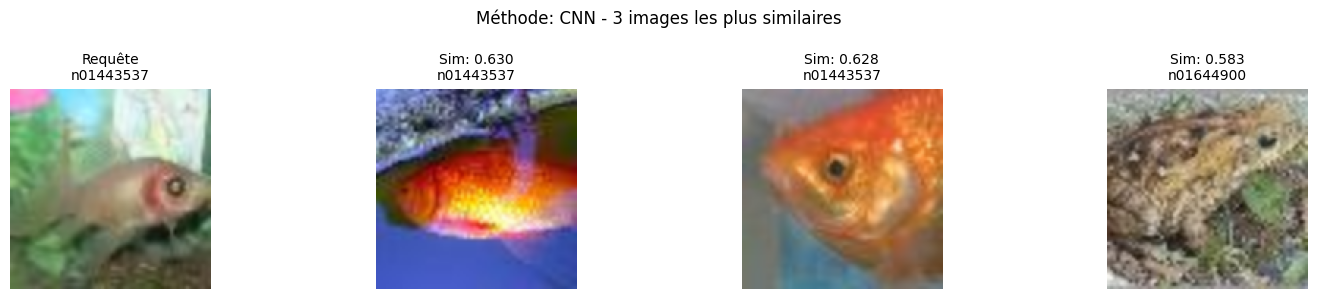


Résultats pour la méthode CNN (Image requête: n01443537):
  Rang 1: Image 3 (n01443537) - Similarité: 0.6295
  Rang 2: Image 4 (n01443537) - Similarité: 0.6276
  Rang 3: Image 17 (n01644900) - Similarité: 0.5825


In [15]:
# Test avec une image requête
image_requete_idx = 0
methode_test = "CNN"
k_test = 3

# Appel de la fonction
afficher_resultats(image_requete_idx, methode_test, k_test)